### Summary
1. Load in the insider transaction datasets.
2. Combine transactions occurred on the same date
    - Add columns for the transaction codes with the sum of transaction shares for each
3. Handle market days with no corresponding transactions
    - The data includes the market data with no corresponding insider transaction data, the most recent transaction is used.
    - The data excludes insider transactions with no corresponding market data
4. Model building and testing
    ```
    X = goog_data[features]
    y = goog_data['daily_return']
    ```
5. Evaluate the model:
    ```
    Mean Squared Error: 0.00015804596223832772
    Root Mean Squared Error: 0.012571633236709052
    Mean Absolute Error: 0.008410617720151736
    R-Squared: 0.519577559695581
    ```
6. Cross-validation and visualization  
    `Cross-validated MSE: 0.00017239257586487106`  
    
7. Train the model with `goog_data['daily_return_ndxt']` as target
    ```
    Mean Squared Error: 0.00014684223448716547
    Root Mean Squared Error: 0.012117847766297672
    Mean Absolute Error: 0.008661956664049196
    R-Squared: 0.4723718773490978
    Cross-validated MSE: 0.0001544211352554544
    ```
8. Summary:
    - __R-squared__: The model explains about 52% of the variance in Google's daily returns.  
    - __RMSE__: RMSE larger than the average daily return (0.00074) means volatility in the predictions.  
    - __Cross-validation__: Cross-validated MSE is slightly larger than the MSE on the __daily_return_ndxt__ test set, meaning the prediction is depending on some subset of the data
9. Train the model with meta, illumina, zoom, and amazon data
10. Insider transaction activities in illumina, zoom, and amazon are quite lower than the them in google & meta. The sparsity can be handled with other solutions. 
    ```
    Metrics for Meta:
    Mean Squared Error: 0.0004323483091093814
    Root Mean Squared Error: 0.020792987017486962
    Mean Absolute Error: 0.012574608864811538
    R-Squared: 0.4291769694727082
    Cross-validated MSE: 0.000498047843783031

    Metrics for Illumina:
    Mean Squared Error: 0.0005757982422908124
    Root Mean Squared Error: 0.023995796346252242
    Mean Absolute Error: 0.014786902763449879
    R-Squared: 0.3395326885718619
    Cross-validated MSE: 0.0006146489574753441

    Metrics for Zoom:
    Mean Squared Error: 0.0011568781369370262
    Root Mean Squared Error: 0.034012911326980325
    Mean Absolute Error: 0.02308242140243179
    R-Squared: 0.23923025642492146
    Cross-validated MSE: 0.001228427247516309

    Metrics for Amazon:
    Mean Squared Error: 0.0002625801802947473
    Root Mean Squared Error: 0.016204325974712656
    Mean Absolute Error: 0.011245919952029332
    R-Squared: 0.5071666972001632
    Cross-validated MSE: 0.0002717398659470168
    ```

In [1]:
import pandas as pd

goog_trans = pd.read_csv('data/goog_trans.csv')

goog_trans

,TRANS_DATE,TRANS_CODE,TRANS_SHARES
0,2017-07-28,S,102.0
1,2017-07-28,S,423.0
2,2017-08-25,C,2625.0
3,2017-08-25,F,2866.0
4,2017-08-25,C,2625.0
...,...,...,...
87352,2018-02-26,C,2768.0
87353,2018-02-26,C,2901.0
87354,2018-03-01,S,37.0
87355,2018-02-01,S,38.0


In [3]:
goog_trans = goog_trans.groupby(['TRANS_DATE', 'TRANS_CODE']).agg({'TRANS_SHARES': 'sum'}).reset_index()

goog_trans

,TRANS_DATE,TRANS_CODE,TRANS_SHARES
0,2006-01-03,C,135000.0
1,2006-01-03,M,2541.0
2,2006-01-03,S,363328.0
3,2006-01-04,C,132000.0
4,2006-01-04,S,142480.0
...,...,...,...
4320,2023-03-16,S,75000.0
4321,2023-03-25,C,332864.0
4322,2023-03-25,F,161347.0
4323,2023-03-29,S,29006.0


In [4]:
goog_trans = goog_trans.groupby(['TRANS_DATE', 'TRANS_CODE']).agg({'TRANS_SHARES': 'sum'}).reset_index()

goog_trans = goog_trans.pivot(index='TRANS_DATE', columns='TRANS_CODE', values='TRANS_SHARES')

goog_trans.fillna(0, inplace=True)


goog_trans.head()

TRANS_CODE,A,C,D,F,G,M,P,S
TRANS_DATE,,,,,,,,
2006-01-03,0.0,135000.0,0.0,0.0,0.0,2541.0,0.0,363328.0
2006-01-04,0.0,132000.0,0.0,0.0,0.0,0.0,0.0,142480.0
2006-01-05,0.0,143000.0,0.0,0.0,0.0,0.0,0.0,143480.0
2006-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10480.0
2006-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10482.0


In [5]:
goog_stock = pd.read_csv('data/goog_stock.csv')

goog_stock.set_index('Date', inplace=True)

goog_stock

,daily_return,cumulative_return,daily_return_ndxt
Date,,,
2006-02-22,-0.003001,0.064575,NaN
2006-02-23,0.034420,0.104241,-0.003741
2006-02-24,-0.001772,0.029853,0.002854
2006-02-27,0.034393,0.058658,0.008893
2006-02-28,-0.071110,-0.010830,-0.010998
...,...,...,...
2023-03-23,0.019574,0.051351,0.024057
2023-03-24,-0.001882,0.035136,-0.010070
2023-03-27,-0.028286,0.011086,-0.007583


In [6]:
goog_data = pd.merge(goog_stock, goog_trans, how='outer', left_index=True, right_index=True)

goog_data

,daily_return,cumulative_return,daily_return_ndxt,A,C,D,F,G,M,P,S
2006-01-03,NaN,NaN,NaN,0.0,135000.0,0.0,0.0,0.0,2541.0,0.0,363328.0
2006-01-04,NaN,NaN,NaN,0.0,132000.0,0.0,0.0,0.0,0.0,0.0,142480.0
2006-01-05,NaN,NaN,NaN,0.0,143000.0,0.0,0.0,0.0,0.0,0.0,143480.0
2006-01-06,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10480.0
2006-01-09,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10482.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-25,NaN,NaN,NaN,0.0,332864.0,0.0,161347.0,0.0,0.0,0.0,0.0
2023-03-27,-0.028286,0.011086,-0.007583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-28,-0.016495,-0.042328,-0.006203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-29,0.005328,-0.022261,0.025247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29006.0


In [7]:
codes = ['A', 'C', 'D', 'F', 'G', 'M', 'P', 'S']
goog_data[codes] = goog_data[codes].fillna(method='ffill')

goog_data.dropna(inplace=True)

goog_data

,daily_return,cumulative_return,daily_return_ndxt,A,C,D,F,G,M,P,S
2006-02-23,0.034420,0.104241,-0.003741,0.0,53940.0,0.0,0.0,0.0,0.0,0.0,60735.0
2006-02-24,-0.001772,0.029853,0.002854,0.0,140.0,0.0,0.0,0.0,0.0,0.0,140.0
2006-02-27,0.034393,0.058658,0.008893,0.0,33896.0,0.0,0.0,0.0,0.0,0.0,140.0
2006-02-28,-0.071110,-0.010830,-0.010998,0.0,56493.0,0.0,0.0,5000.0,0.0,0.0,56493.0
2006-03-01,0.006012,-0.001888,0.025123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50630.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-23,0.019574,0.051351,0.024057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75000.0
2023-03-24,-0.001882,0.035136,-0.010070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75000.0
2023-03-27,-0.028286,0.011086,-0.007583,0.0,332864.0,0.0,161347.0,0.0,0.0,0.0,0.0
2023-03-28,-0.016495,-0.042328,-0.006203,0.0,332864.0,0.0,161347.0,0.0,0.0,0.0,0.0


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

features = ['daily_return_ndxt', 'cumulative_return', 'A', 'C', 'D', 'F', 'G', 'M', 'P', 'S']

X = goog_data[features]
y = goog_data['daily_return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MSE: ", mean_squared_error(y_test, y_pred))

MSE:  0.00015804596223832772


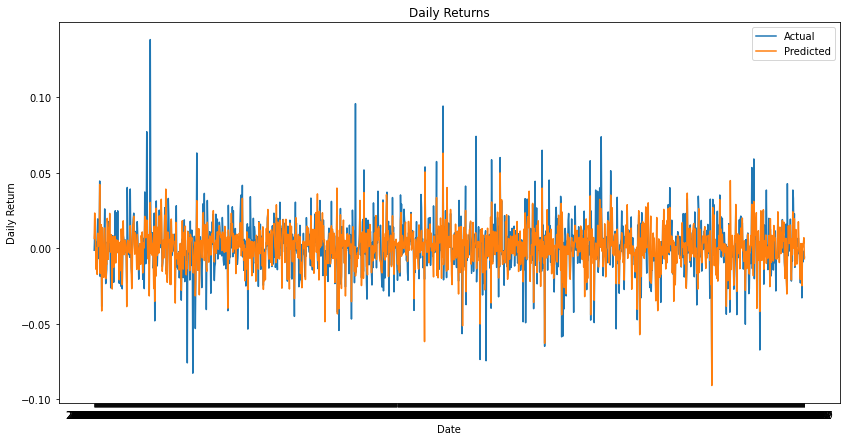

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

In [10]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('R-Squared:', r2)

Mean Squared Error: 0.00015804596223832772
Root Mean Squared Error: 0.012571633236709052
Mean Absolute Error: 0.008410617720151736
R-Squared: 0.519577559695581


Cross-validated MSE: 0.00017239257586487106


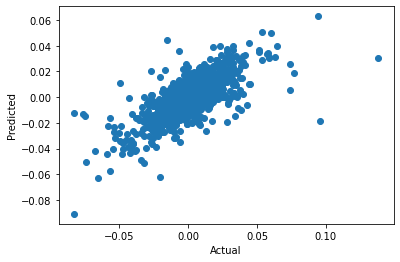

In [11]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated MSE:", -scores.mean())

plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [12]:
goog_data['daily_return'].mean()

0.000746122602600735

In [13]:
import joblib

joblib.dump(model, 'model/google_model.pkl')

['model/google_model.pkl']

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

features = ['daily_return_ndxt', 'cumulative_return', 'A', 'F', 'M', 'P', 'S']

X = goog_data[features]
y = goog_data['daily_return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MSE: ", mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('R-Squared:', r2)

MSE:  0.00015686412934605
Root Mean Squared Error: 0.012571633236709052
Mean Absolute Error: 0.008410617720151736
R-Squared: 0.519577559695581


In [31]:
trans = pd.read_csv('data/meta_trans.csv')

trans = trans.groupby(['TRANS_DATE', 'TRANS_CODE']).agg({'TRANS_SHARES': 'sum'}).reset_index()

trans = trans.pivot(index='TRANS_DATE', columns='TRANS_CODE', values='TRANS_SHARES')
trans.fillna(0, inplace=True)

trans

TRANS_CODE,A,C,F,G,M,P,S
TRANS_DATE,,,,,,,
2011-02-01,0.0,7500.0,0.0,0.0,0.0,0.0,0.0
2012-05-17,0.0,0.0,0.0,0.0,0.0,0.0,24324886.0
2012-05-22,0.0,691772044.0,0.0,0.0,0.0,0.0,334544829.0
2012-08-08,0.0,9297884.0,0.0,0.0,0.0,47846.0,0.0
2012-08-16,0.0,5680668.0,0.0,0.0,0.0,0.0,13000000.0
...,...,...,...,...,...,...,...
2023-02-28,0.0,0.0,0.0,0.0,0.0,0.0,393.0
2023-03-07,0.0,0.0,0.0,0.0,0.0,0.0,393.0
2023-03-14,0.0,0.0,0.0,0.0,0.0,0.0,393.0


In [33]:
stock = pd.read_csv('data/meta_stock.csv')
stock.set_index('Date', inplace=True)

data = pd.merge(stock, trans, how='outer', left_index=True, right_index=True)

codes = ['A', 'C', 'F', 'G', 'M', 'P', 'S']

data[codes] = data[codes].fillna(method='ffill')

data.dropna(inplace=True)

meta_data = data

meta_data

,daily_return,cumulative_return,daily_return_ndxt,A,C,F,G,M,P,S
2012-05-25,-0.033909,-0.165315,0.005100,0.0,691772044.0,0.0,0.0,0.0,0.0,334544829.0
2012-05-29,-0.096208,-0.152512,0.013720,0.0,691772044.0,0.0,0.0,0.0,0.0,334544829.0
2012-05-30,-0.022538,-0.090645,-0.018362,0.0,691772044.0,0.0,0.0,0.0,0.0,334544829.0
2012-05-31,0.050018,-0.075000,-0.008696,0.0,691772044.0,0.0,0.0,0.0,0.0,334544829.0
2012-06-01,-0.063514,-0.160763,-0.029433,0.0,691772044.0,0.0,0.0,0.0,0.0,334544829.0
...,...,...,...,...,...,...,...,...,...,...
2023-03-23,0.022371,-0.003172,0.024057,0.0,0.0,0.0,0.0,0.0,0.0,393.0
2023-03-24,0.008469,0.053167,-0.010070,0.0,0.0,0.0,0.0,0.0,0.0,393.0
2023-03-27,-0.015388,0.025428,-0.007583,0.0,0.0,0.0,0.0,0.0,0.0,393.0
2023-03-28,-0.010649,-0.007321,-0.006203,0.0,0.0,0.0,0.0,0.0,0.0,393.0


In [35]:
# Illumina
trans = pd.read_csv('data/ilmn_trans.csv')

trans = trans.groupby(['TRANS_DATE', 'TRANS_CODE']).agg({'TRANS_SHARES': 'sum'}).reset_index()

trans = trans.pivot(index='TRANS_DATE', columns='TRANS_CODE', values='TRANS_SHARES')
trans.fillna(0, inplace=True)

trans

TRANS_CODE,A,D,F,G,M,P,S
TRANS_DATE,,,,,,,
2006-01-04,0.0,0.0,0.0,0.0,0.0,0.0,5000.0
2006-01-10,0.0,0.0,0.0,0.0,0.0,0.0,9958.0
2006-01-13,0.0,0.0,0.0,0.0,0.0,0.0,4542.0
2006-01-19,0.0,0.0,0.0,0.0,0.0,0.0,5000.0
2006-01-20,0.0,0.0,0.0,1812.0,0.0,0.0,9000.0
...,...,...,...,...,...,...,...
2023-01-09,0.0,0.0,0.0,0.0,0.0,0.0,871.0
2023-02-06,0.0,0.0,0.0,0.0,0.0,0.0,500.0
2023-02-21,0.0,0.0,24268.0,0.0,61302.0,0.0,0.0


In [36]:
stock = pd.read_csv('data/ilmn_stock.csv')
stock.set_index('Date', inplace=True)

data = pd.merge(stock, trans, how='outer', left_index=True, right_index=True)

codes = ['A', 'D', 'F', 'G', 'M', 'P', 'S']

data[codes] = data[codes].fillna(method='ffill')

data.dropna(inplace=True)

ilmn_data = data

ilmn_data

,daily_return,cumulative_return,daily_return_ndxt,A,D,F,G,M,P,S
2006-02-23,-0.002813,0.077758,-0.003741,0.0,0.0,0.0,0.0,0.0,0.0,7000.0
2006-02-24,0.010480,0.035523,0.002854,0.0,0.0,0.0,0.0,0.0,0.0,7000.0
2006-02-27,0.005186,0.035333,0.008893,0.0,0.0,0.0,0.0,0.0,0.0,7000.0
2006-02-28,0.009127,0.055625,-0.010998,0.0,0.0,0.0,0.0,0.0,0.0,7000.0
2006-03-01,0.022414,0.045016,0.025123,0.0,0.0,0.0,0.0,0.0,0.0,7000.0
...,...,...,...,...,...,...,...,...,...,...
2023-03-23,-0.001059,-0.035563,0.024057,109303.0,0.0,0.0,0.0,0.0,0.0,3917.0
2023-03-24,0.014059,-0.020263,-0.010070,109303.0,0.0,0.0,0.0,0.0,0.0,3917.0
2023-03-27,-0.009909,-0.008873,-0.007583,109303.0,0.0,0.0,0.0,0.0,0.0,3917.0
2023-03-28,-0.018272,-0.035062,-0.006203,109303.0,0.0,0.0,0.0,0.0,0.0,3917.0


In [38]:
# Amazon
trans = pd.read_csv('data/amzn_trans.csv')

trans = trans.groupby(['TRANS_DATE', 'TRANS_CODE']).agg({'TRANS_SHARES': 'sum'}).reset_index()

trans = trans.pivot(index='TRANS_DATE', columns='TRANS_CODE', values='TRANS_SHARES')
trans.fillna(0, inplace=True)

trans

TRANS_CODE,D,G,M,P,S
TRANS_DATE,,,,,
2006-01-03,20000.0,0.0,0.0,0.0,0.0
2006-01-09,0.0,0.0,2039.0,0.0,870.0
2006-02-07,0.0,3999.0,0.0,0.0,0.0
2006-02-15,0.0,0.0,101250.0,0.0,101250.0
2006-02-21,0.0,0.0,17497.0,0.0,17497.0
...,...,...,...,...,...
2023-02-22,0.0,260662.0,0.0,0.0,0.0
2023-02-23,0.0,16789.0,0.0,0.0,0.0
2023-03-01,0.0,168956.0,0.0,0.0,4000.0


In [39]:
stock = pd.read_csv('data/amazon_stock.csv')
stock.set_index('Date', inplace=True)

data = pd.merge(stock, trans, how='outer', left_index=True, right_index=True)

codes = ['D', 'G', 'M', 'P', 'S']

data[codes] = data[codes].fillna(method='ffill')

data.dropna(inplace=True)

amzn_data = data

amzn_data

,daily_return,cumulative_return,daily_return_ndxt,D,G,M,P,S
2006-02-23,-0.021178,-0.034641,-0.003741,0.0,0.0,17497.0,0.0,17497.0
2006-02-24,0.011873,-0.020434,0.002854,0.0,0.0,17497.0,0.0,17497.0
2006-02-27,-0.008866,-0.030110,0.008893,0.0,0.0,17497.0,0.0,17497.0
2006-02-28,-0.014996,-0.022199,-0.010998,0.0,0.0,17497.0,0.0,17497.0
2006-03-01,-0.008547,-0.041322,0.025123,0.0,0.0,17497.0,0.0,17497.0
...,...,...,...,...,...,...,...,...
2023-03-23,0.000101,-0.013295,0.024057,0.0,0.0,0.0,0.0,2299.0
2023-03-24,-0.005876,-0.008287,-0.010070,0.0,0.0,0.0,0.0,2299.0
2023-03-27,-0.000917,0.003377,-0.007583,0.0,0.0,0.0,0.0,2299.0
2023-03-28,-0.008160,-0.033496,-0.006203,0.0,0.0,0.0,0.0,2299.0


In [40]:
# Zoom
trans = pd.read_csv('data/zoom_trans.csv')

trans = trans.groupby(['TRANS_DATE', 'TRANS_CODE']).agg({'TRANS_SHARES': 'sum'}).reset_index()

trans = trans.pivot(index='TRANS_DATE', columns='TRANS_CODE', values='TRANS_SHARES')
trans.fillna(0, inplace=True)

trans

TRANS_CODE,A,C,D,F,G,M,P,S
TRANS_DATE,,,,,,,,
2019-04-15,0.0,1340000.0,0.0,0.0,0.0,0.0,0.0,340000.0
2019-04-23,0.0,5725625.0,0.0,0.0,0.0,0.0,350000.0,6725624.0
2019-07-18,0.0,85908.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-09,0.0,1379818.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-30,0.0,16797.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-03-13,0.0,3224.0,0.0,0.0,0.0,0.0,0.0,3224.0
2023-03-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7000.0
2023-03-18,0.0,0.0,0.0,0.0,0.0,472.0,0.0,0.0


In [41]:
stock = pd.read_csv('data/zoom_stock.csv')
stock.set_index('Date', inplace=True)

data = pd.merge(stock, trans, how='outer', left_index=True, right_index=True)

codes = ['A', 'C', 'D', 'F', 'G', 'M', 'P', 'S']

data[codes] = data[codes].fillna(method='ffill')

data.dropna(inplace=True)

zoom_data = data

zoom_data

,daily_return,cumulative_return,daily_return_ndxt,A,C,D,F,G,M,P,S
2019-04-26,0.018769,0.068065,-0.000769,0.0,5725625.0,0.0,0.0,0.0,0.0,350000.0,6725624.0
2019-04-29,0.029447,0.037595,-0.000345,0.0,5725625.0,0.0,0.0,0.0,0.0,350000.0,6725624.0
2019-04-30,0.063078,0.050290,0.005030,0.0,5725625.0,0.0,0.0,0.0,0.0,350000.0,6725624.0
2019-05-01,0.004002,0.151266,-0.009200,0.0,5725625.0,0.0,0.0,0.0,0.0,350000.0,6725624.0
2019-05-02,0.037658,0.161538,0.001935,0.0,5725625.0,0.0,0.0,0.0,0.0,350000.0,6725624.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-23,0.006400,-0.019833,0.024057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7000.0
2023-03-24,-0.002168,-0.002168,-0.010070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7000.0
2023-03-27,-0.006808,-0.010534,-0.007583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7000.0
2023-03-28,-0.000437,-0.046068,-0.006203,0.0,3224.0,0.0,0.0,0.0,0.0,0.0,10224.0


In [42]:
company_names = ['Meta', 'Illumina', 'Zoom', 'Amazon']
company_data = [meta_data, ilmn_data, zoom_data, amzn_data]

for name, data in zip(company_names, company_data):
    X = data.drop('daily_return', axis=1)
    y = data['daily_return']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    
    #joblib.dump(model, f'model/{name}_model.pkl')

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    cv_mse = -cross_val_score(model, X_test, y_test, cv=5, scoring='neg_mean_squared_error').mean()

    print(f'Metrics for {name}:')
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R-Squared: {r2}')
    print(f'Cross-validated MSE: {cv_mse}')
    print('\n')

Metrics for Meta:
Mean Squared Error: 0.0004315467569939149
Root Mean Squared Error: 0.020773703497304348
Mean Absolute Error: 0.01255694708688122
R-Squared: 0.43023524678763214
Cross-validated MSE: 0.0004559326976510443


Metrics for Illumina:
Mean Squared Error: 0.0005757982422908124
Root Mean Squared Error: 0.023995796346252242
Mean Absolute Error: 0.014786902763449879
R-Squared: 0.3395326885718619
Cross-validated MSE: 0.0006146489574753441


Metrics for Zoom:
Mean Squared Error: 0.0011568781369370262
Root Mean Squared Error: 0.034012911326980325
Mean Absolute Error: 0.02308242140243179
R-Squared: 0.23923025642492146
Cross-validated MSE: 0.001228427247516309


Metrics for Amazon:
Mean Squared Error: 0.0002625801802947473
Root Mean Squared Error: 0.016204325974712656
Mean Absolute Error: 0.011245919952029332
R-Squared: 0.5071666972001632
Cross-validated MSE: 0.0002717398659470168


